In [ ]:
# init repo notebook
!git clone https://github.com/rramosp/ppdl.git
!mv ppdl/content/init.py ppdl/content/local .

# 4. DistributionLambda


In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
from scipy.integrate import quad
from progressbar import progressbar as pbar
from rlxutils import subplots, copy_func

import tensorflow as tf
import tensorflow_probability as tfp
tfd = tfp.distributions
tfb = tfp.bijectors

%matplotlib inline

2022-02-20 07:56:50.326703: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-02-20 07:56:50.326739: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [2]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "-1"


## Using distribution objects in Keras models

TFP provides several layer objects so that we can include distributions in Keras models. This is useful because this would allow us to _learn_ distribution parameters with the regular model machinery of Keras, such as using `Dense` layers, transforming data, etc.

## `tfp.layers.VariableLayer` 

Simply produces a constant value that can be trainable. It is equivalent to a `Dense` Keras layer with the kernel set to zero and only the bias trainable. The output is the same (constant) for any input of any size. It is used to provide values to posterior layers which do not depend on input data (such as paratemeters of distributions).

In [9]:
vl = tfp.layers.VariableLayer(shape=(3,2))
vl

In [10]:
x = np.random.random(size=(10,4))
vl(x)

<tf.Tensor: shape=(3, 2), dtype=float32, numpy=
array([[0., 0.],
       [0., 0.],
       [0., 0.]], dtype=float32)>

the `initializer` defines the initial constant value. See [`tf.keras.initializers`](https://www.tensorflow.org/api_docs/python/tf/keras/initializers) and [`tfp.layers.BlockwiseInitializer`](https://www.tensorflow.org/probability/api_docs/python/tfp/layers/BlockwiseInitializer)

In [11]:
vl = tfp.layers.VariableLayer(shape=(3,2), initializer="ones")
vl(x)

<tf.Tensor: shape=(3, 2), dtype=float32, numpy=
array([[1., 1.],
       [1., 1.],
       [1., 1.]], dtype=float32)>

In [14]:
vl = tfp.layers.VariableLayer(
            shape=(3,2), 
            initializer=tf.keras.initializers.RandomNormal(mean=0., stddev=1.)
     )

vl(x)

<tf.Tensor: shape=(3, 2), dtype=float32, numpy=
array([[-1.3975693,  1.2439306],
       [-1.4463489, -1.8343785],
       [ 1.1516911, -0.4883429]], dtype=float32)>

the `BlockwiseInitializer` concatenates other initializers and dimensions must be broadcastable

In [15]:
vl = tfp.layers.VariableLayer(shape=(3,2), initializer=
    tfp.layers.BlockwiseInitializer([
          'zeros',
           tf.keras.initializers.Constant(np.log(np.expm1(1.))),  # = 0.541325
        ], 
        sizes=[1, 1])
    )

vl(x)

<tf.Tensor: shape=(3, 2), dtype=float32, numpy=
array([[0.        , 0.54132485],
       [0.        , 0.54132485],
       [0.        , 0.54132485]], dtype=float32)>

# the `tfp.layers.DistributionLambda` layer

They provide a wrapper for `tfp` distribution objects so that they can be integrated in Keras models. Observe that **their parameter is a function**, so that it can be invoked by Keras within a `GradientTape`.

We can **choose** to use variables for distribution the distribution parameters, and use the input data **ONLY** to evaluate the loss.

Observe we use a `VariableLayer` to **create** a variable in the middle of the model

In [16]:
x = 5*tfd.Beta(2.,5).sample(10000)+2

In [17]:
inp = tf.keras.layers.Input(shape=(1,))
var = tfp.layers.VariableLayer(shape=(2), initializer="ones")(inp)
out = tfp.layers.DistributionLambda(lambda t: tfd.Normal(loc=t[0], scale=tf.math.softplus(t[1])))(var)

m   = tf.keras.models.Model(inp, out)

2022-02-20 07:57:04.730721: W tensorflow/python/util/util.cc:368] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.


In [18]:
m.weights

[<tf.Variable 'constant:0' shape=(2,) dtype=float32, numpy=array([1., 1.], dtype=float32)>]

we get always the **same distribution** regardless the input, in this case with mean and `softplus` std as initialized in the `VariableLayer`.


In [19]:
_x = m([np.random.random()]).sample(100000).numpy()
_x.mean(), _x.std(), tf.math.softplus(1.).numpy()

(1.0002679, 1.3119836, 1.3132616)

the loss function takes the **target** and the model output. **NOTICE** that the model output is a **distribution object**, so we can use its methods.

In [20]:
negloglik = lambda x, distribution: -distribution.log_prob(x)
m.compile(optimizer='adam', loss=negloglik)

In [21]:
negloglik(x, tfd.Normal(0,1))

<tf.Tensor: shape=(10000,), dtype=float32, numpy=
array([4.533191 , 5.8602905, 8.682795 , ..., 5.0683117, 6.6048856,
       4.1267476], dtype=float32)>

the model does not use the input, we only to provide the **target** to the `.fit` so that it can pass it on  to the loss function.

In [22]:
dummy_input = np.random.random(len(x))
m.fit(dummy_input, x, epochs=40, verbose=0)

In [23]:
# the weights are in the variables of the VariableLayer
m.weights

[<tf.Variable 'constant:0' shape=(2,) dtype=float32, numpy=array([3.4179287 , 0.20450164], dtype=float32)>]

This is a **very particular** setting, since **the output DOES NOT depend on the input**, it is just a distribution whose parameters have been previously learnt. The target is **only used in the loss function**. Once training is complete the loss function is not needed anymore.

In [24]:
distribution = m([np.random.random()])

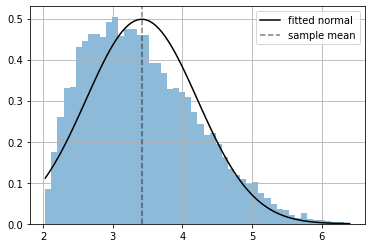

In [25]:
xr = np.linspace(np.min(x), np.max(x), 100)
plt.hist(x.numpy(), bins=50, density=True, alpha=.5);
plt.plot(xr, np.exp(distribution.log_prob(xr).numpy()), color="black", label="fitted normal");
plt.axvline(np.mean(x), ls="--", color="black", alpha=.5, label="sample mean")
plt.grid(); plt.legend();

## Learning a distribution for each input data point

The setting above seems a bit unnatural for Keras. In fact, the full power of TFP unveils when we **learn** a distribution for each input data point. 

More in depth observe that:

- The output of the layer **when using the implicit `call`** method of the layer is a distribution.
- The output of the layer **when using the `predict`** method of a model is a sample from the distribution.
- It can use the output of previous layers as parameters for the distribution

For comparison consider a model with a regular keras model, where `call` and `predict` have the same behaviour.

In [28]:
inp  = tf.keras.layers.Input(shape=(1,))
out  = tf.keras.layers.Dense(2)(inp)
m    = tf.keras.models.Model(inp, out)

In [29]:
x = np.r_[1.,2.,3.].reshape(-1,1)

In [30]:
# using the implicit call method of the model
m(x)

<tf.Tensor: shape=(3, 2), dtype=float32, numpy=
array([[-1.0067325,  1.0000728],
       [-2.013465 ,  2.0001457],
       [-3.0201974,  3.0002184]], dtype=float32)>

In [31]:
# using the implicit call method of the layer
m.layers[1](x)

<tf.Tensor: shape=(3, 2), dtype=float32, numpy=
array([[-1.0067325,  1.0000728],
       [-2.013465 ,  2.0001457],
       [-3.0201974,  3.0002184]], dtype=float32)>

In [32]:
# using the predict method of the model
m.predict(x)

array([[-1.0067325,  1.0000728],
       [-2.013465 ,  2.0001457],
       [-3.0201974,  3.0002184]], dtype=float32)

Now with a `DistributionLambda` layer. Observe that **we choose** to use the output of the previous layer to be  the mean (first column) and std (second column) of the distribution

In [33]:
inp = tf.keras.layers.Input(shape=(2,))
out = tfp.layers.DistributionLambda(lambda t: tfd.Normal(loc=t[:,0], scale=t[:,1]))(inp)

m   = tf.keras.models.Model(inp, out)

In [34]:
x = np.r_[1.,2.,10.,4.,20.,6.].reshape(3,2)
x

array([[ 1.,  2.],
       [10.,  4.],
       [20.,  6.]])

we implicitly use the `call` method of our model. Observe we get **one distribution for each input data**, which shows up in the `batch_size`.

In [35]:
m(x)

<tfp.distributions._TensorCoercible 'tensor_coercible' batch_shape=[3] event_shape=[] dtype=float32>

which is the same as if we call directly the `DistributionLambda` layer object.

In [36]:
m.layers[1](x)

<tfp.distributions._TensorCoercible 'tensor_coercible' batch_shape=[3] event_shape=[] dtype=float32>

we can sample this output distribution. Each sample will contain three elements, one per data point following a normal distribution parametrized by the two elements of the data point (mean and std).

In [37]:
_x = m(x).sample(100000).numpy()
_x.shape

(100000, 3)

In [38]:
_x.mean(axis=0), _x.std(axis=0)

(array([ 1.004689,  9.983776, 19.96568 ], dtype=float32),
 array([2.003365 , 3.9917862, 5.986713 ], dtype=float32))

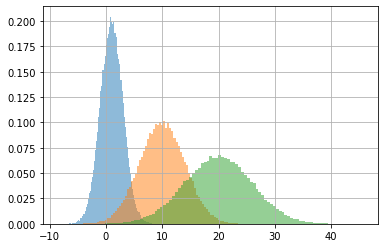

In [39]:
for i in range(len(x)):
    plt.hist(_x[:,i], density=True, bins=100, alpha=.5)
plt.grid();

In this case, the `.predict` method **behaves differently** from the implicit `call`. It produces a sample following the input data.

This behaviour can be changed by the `convert_to_tensor_fn` argument. See the [DistributionLambda](https://www.tensorflow.org/probability/api_docs/python/tfp/layers/DistributionLambda) docs. So that you could return the distribution mean, or any other representative value you want to have as a result of a predictions. Sampling from the distribution corresponding to each input data point is a generally convenient choice for generative models.


In [40]:
# the predictions (samples) follow the distributions parametrized by x
x = np.concatenate([np.r_[[[0,1]]*40000], np.r_[[[10,3]]*50000]])
x.shape

(90000, 2)

In [41]:
_x = m.predict(x)
_x.shape

(90000,)

In [42]:
_x[:40000].mean(), _x[:40000].std(), "::", _x[40000:].mean(), _x[40000:].std()

(-0.0049270834, 1.0014801, '::', 9.986944, 3.0177207)

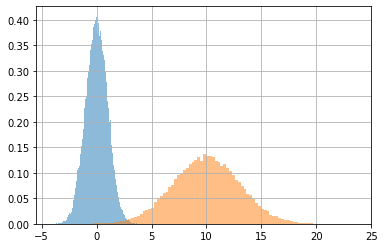

In [43]:
plt.hist(_x[:40000], alpha=.5, density=True, bins=100)
plt.hist(_x[40000:], alpha=.5, density=True, bins=100);
plt.grid();

# Learning distribution parameters

We have not fit any model yet, but we can use this machinery to **learn** the distribution parameters for each input data point with a small `Dense` layer.


We are trying to learn this model


$$
\begin{align}
\mu_x, \sigma_x &= D_\theta(x) \\
y &\sim \mathcal{N}(\mu_x, \sigma_x)
\end{align}
$$

where $D_\theta$ is a regular neural network with parameters $\theta$ which, given an input $x$, returns two values $\mu_x$ and $\sigma_x$. These two values will be used to parametrize a gaussian distribution for that specific $x$.

and we want $\theta$ that maximizes the log likelihood.


$$\underset{\theta}{\text{arg min}}\;\; - \frac{1}{N} \sum_{x_i} \log P_{\mathcal{N}(\mu_{x_i}, \sigma_{x_i})}(x_i)$$

Observe that, this way, we have a **predictive distribution** for each input data point.

In [44]:
n_points = 300
k = 2
x = np.linspace(0, 10, n_points)
y = .3*x+2*np.sin(x/1.5) + (.2+.02* ((x-5)*k)**2) * np.random.randn(n_points)

Text(0, 0.5, 'y')

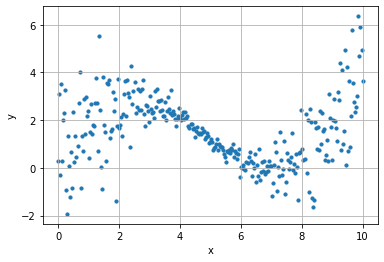

In [45]:
plt.scatter(x, y, s=10)
plt.grid();
plt.xlabel("x"); plt.ylabel("y")

In [46]:
inp  = tf.keras.layers.Input(shape=(1,))
out  = tf.keras.layers.Dense(10, activation="tanh")(inp)
out  = tf.keras.layers.Dense(10, activation="tanh")(out)
out  = tf.keras.layers.Dense(2)(out)
out  = tfp.layers.DistributionLambda(lambda t: tfd.Normal(loc=t[:,0], scale=tf.math.softplus(t[:,1])))(out)

m    = tf.keras.models.Model(inp, out)

In [47]:
m.summary()

Model: "model_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_5 (InputLayer)        [(None, 1)]               0         
                                                                 
 dense_2 (Dense)             (None, 10)                20        
                                                                 
 dense_3 (Dense)             (None, 10)                110       
                                                                 
 dense_4 (Dense)             (None, 2)                 22        
                                                                 
 distribution_lambda_2 (Dist  ((None,),                0         
 ributionLambda)              (None,))                           
                                                                 
Total params: 152
Trainable params: 152
Non-trainable params: 0
_____________________________________________________________

In [48]:
negloglik = lambda x, distribution: -distribution.log_prob(x)
m.compile(optimizer='adam', loss=negloglik)

In [49]:
history = m.fit(x,y, epochs=2000, verbose=0)

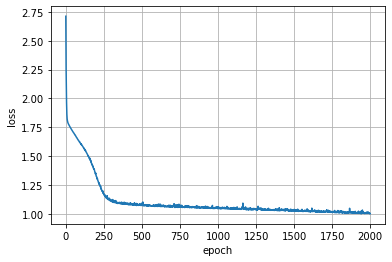

In [50]:
plt.plot(history.epoch, history.history['loss'])
plt.grid(); plt.xlabel("epoch"); plt.ylabel("loss");

get the predictive distributions for each input data point

In [51]:
_y = m(x)
_y

<tfp.distributions._TensorCoercible 'tensor_coercible' batch_shape=[300] event_shape=[] dtype=float32>

observe the parameters learn for each datapoint

In [60]:
_x = np.r_[2]

Text(0, 0.5, 'y')

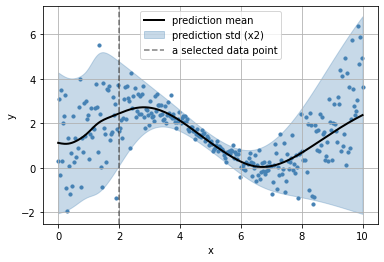

In [53]:
plt.scatter(x, y, s=10, color="steelblue")
plt.plot(x, _y.parameters['loc'], color="black", lw=2, label="prediction mean")
plt.fill_between(x, 
                 _y.parameters['loc'] + 2*_y.parameters['scale'], 
                 _y.parameters['loc'] - 2*_y.parameters['scale'], alpha=.3, 
                 color="steelblue",
                 label="prediction std (x2)")
plt.axvline(_x[0], color="black", ls="--", alpha=.5, label="a selected data point")
plt.grid(); plt.legend();
plt.xlabel("x"); plt.ylabel("y")

we can also see how it generlizes outside the input variable bounds

In [ ]:
xr = np.linspace(np.min(x)-10, np.max(x)+10, 100)
yr = m(xr)

Text(0, 0.5, 'y')

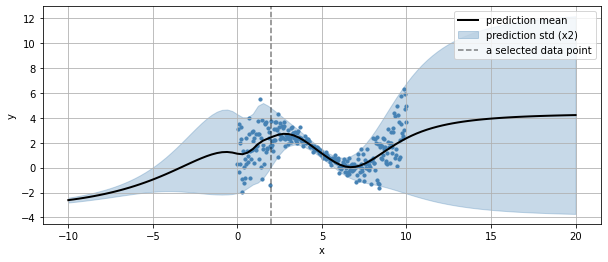

In [69]:
plt.figure(figsize=(10,4))
plt.scatter(x, y, s=10, color="steelblue")
plt.plot(xr, yr.parameters['loc'], color="black", lw=2, label="prediction mean")
plt.fill_between(xr, 
                 yr.parameters['loc'] + 2*yr.parameters['scale'], 
                 yr.parameters['loc'] - 2*yr.parameters['scale'], alpha=.3, 
                 color="steelblue",
                 label="prediction std (x2)")
plt.axvline(_x[0], color="black", ls="--", alpha=.5, label="a selected data point")
plt.grid(); plt.legend();
plt.xlabel("x"); plt.ylabel("y")

we can get the **predictive distribution** of any input data point (such as the selected one above)

In [70]:
_xd = m(_x)
_xd

<tfp.distributions._TensorCoercible 'tensor_coercible' batch_shape=[1] event_shape=[] dtype=float32>

Text(0.5, 0, 'y distribution for x=2')

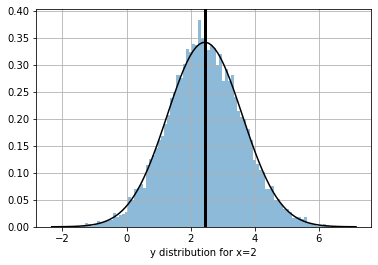

In [71]:
_ys = _xd.sample(10000)[:,0].numpy()
_yr = np.linspace(np.min(_ys), np.max(_ys), 100)
plt.plot(_yr, np.exp(_xd.log_prob(_yr)), color="black", alpha=1)
plt.hist(_ys, bins=100, density=True,  alpha=.5);
plt.axvline(_ys.mean(), color="black", lw=3)
plt.grid(); plt.xlabel(f"y distribution for x={_x[0]}")

and, since we have distributions we also have a generative model using the `.predict` method for sampling.

In [73]:
_x = np.random.random(5000)*14-2
_y = m.predict(_x)

Text(0, 0.5, 'y')

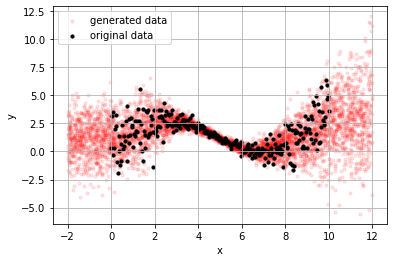

In [74]:
plt.scatter(_x, _y, s=10, alpha=.1, color="red",  label="generated data");
plt.scatter(x, y, s=10, alpha=1, color="black", label="original data")
plt.grid(); plt.legend();
plt.xlabel("x"); plt.ylabel("y")